In [1]:
import polars as pl
import polars.selectors as cs
import plotnine as pn

In [2]:
pl.Config.set_tbl_rows(50)

polars.config.Config

In [2]:
# splits = {
#     "2.8b": "data/2.8b-00000-of-00001.parquet",
#     "1.4b": "data/1.4b-00000-of-00001.parquet",
#     "410m": "data/410m-00000-of-00001.parquet",
#     "70m": "data/70m-00000-of-00001.parquet",
#     "6.9b": "data/6.9b-00000-of-00001.parquet",
#     "12b": "data/12b-00000-of-00001.parquet",
#     "160m": "data/160m-00000-of-00001.parquet",
# }
# df = pl.read_parquet("hf://datasets/pietrolesci/pythia-deduped-stats/" + splits["410m"])
# df = df.with_columns(logp=pl.col("sup_seq").neg())

In [10]:
df = (
    pl.read_parquet("data/410m.parquet")
    .with_columns(
        batch_idx=(
            pl.when(pl.col("seq_idx") < 0)
            .then(-1)
            .otherwise((pl.col("seq_idx") / (1024 * 1000)).ceil().cast(pl.Int32) * 1000)
        )
    )
    .drop(["sup_seq", "entr_seq", "acc_seq", "avg_rank"])
)

In [16]:
val_df = (
    # Filter the never-treated
    df.filter(pl.col("batch_idx") < 0)
    # Compute average performance per step
    .group_by("step").agg(pl.col("logp").mean())
    .sort("step")
)
val_df.head()

step,logp
i32,f64
0,-11.012991
1000,-4.268897
2000,-3.670751
3000,-3.427454
4000,-3.346674


In [17]:
train_df = (
    df.filter(pl.col("batch_idx") > 0)
    # Compute the base step for each batch_idx
    .sort(["batch_idx", "seq_idx", "step"])
    .with_columns(base_step=pl.col("step").shift().over("batch_idx"))
    .drop_nulls(subset=["base_step"])
    .with_columns(
        base_step=(
            pl.when(pl.col("step") >= pl.col("batch_idx"))
            .then(pl.col("batch_idx") - 1000)
            .otherwise(pl.col("base_step"))
        )
    )
)

In [18]:
# Add base_step
train_df = (
    train_df
    .with_columns(base_step=pl.col("step").shift().over("batch_idx"))
    .drop_nulls(subset=["base_step"])
    .with_columns(
        base_step=(
            pl.when(pl.col("step") >= pl.col("batch_idx"))
            .then(pl.col("batch_idx") - 1000)
            .otherwise(pl.col("base_step"))
        )
    )
)

In [19]:
len(train_df)

2058914

In [20]:
# Add base_step performance
train_df = train_df.join(
    train_df.drop("base_step"),
    left_on=["seq_idx", "batch_idx", "base_step"],
    right_on=["seq_idx", "batch_idx", "step"],
    # left_on=["batch_idx", "base_step"],
    # right_on=["batch_idx", "step"],
    suffix="_base",
)
len(train_df)

2058489

In [283]:
train_df = (
    train_df
    # Add validation batch performance at the same step
    .join(val_df, on="step", suffix="_val")
    # Add validation batch performance at the base_step
    .join(val_df, left_on="base_step", right_on="step", suffix="_base_val")
)

In [285]:
# Compute diff-in-diff
train_df = (
    train_df
    .with_columns(
        train_diff=pl.col("logp") - pl.col("logp_base"),
        val_diff=pl.col("logp_val") - pl.col("logp_base_val"),
    )
    .with_columns(mem=pl.col("train_diff") - pl.col("val_diff"))

)

In [21]:
a = train_df

In [163]:
import polars as pl

EXPECTED_LEN = 144 * 143 * 100


# 1. Load the data and compute batch_idx
df = (
    pl.read_parquet("data/410m.parquet")
    .with_columns(
        batch_idx=(
            pl.when(pl.col("seq_idx") < 0)  # Never-treated units
            .then(-1)
            .otherwise(  # Compute batch index for treated units
                (pl.col("seq_idx") / (1024 * 1000)).ceil().cast(pl.Int32) * 1000
            )
        )
    )
    .drop(["sup_seq", "entr_seq", "acc_seq", "avg_rank"])
)

# Check: length is as expected
assert len(df.filter(pl.col("batch_idx") > 0)) == EXPECTED_LEN

# 2. Compute validation (never-treated) average performance by step
val_df = (
    df.filter(pl.col("batch_idx") < 0)  # Never-treated units
    .group_by("step").agg(logp_val=pl.col("logp").mean())  # Average logp
    .sort("step")
)

# Check: length is as expected
assert len(val_df) == 144

# 3. Prepare treated data
train_df = (
    df.filter(pl.col("batch_idx") > 0)  # Only treated units
    .sort(["batch_idx", "seq_idx", "step"])  # Ensure correct order
    # Compute the base step for each batch_idx (pre-treatment step)
    .with_columns(
        base_step=pl.when(pl.col("step") >= pl.col("batch_idx"))
        .then(pl.col("batch_idx") - 1000)  # Treatment period base step
        .otherwise(pl.col("step").shift().over("seq_idx"))  # Pre-treatment step
    )
    # .drop_nulls(subset=["base_step"])  # Drop rows without a valid base step
    # .filter(pl.col("base_step") < pl.col("step").max())
)

# Check: length is as expected
assert len(train_df) == EXPECTED_LEN

# 4. Join base step performance with treated data
train_df = train_df.join(
    train_df.select(["seq_idx", "step", "logp"]),  # Keep seq_idx and base_step on the right side
    left_on=["seq_idx", "base_step"],
    right_on=["seq_idx", "step"],
    suffix="_base",  # Add suffix for base step logp
    how="left",
)

# Check: length is as expected, original minus all units at step 0
assert len(train_df) == EXPECTED_LEN

# 5. Remove empty base period which shuold happen only for step 0
assert len(train_df.filter((pl.col("step") == 0) & (pl.col("base_step")).is_not_null())) == 0
assert len(train_df.filter((pl.col("step") != 0) & (pl.col("base_step")).is_null())) == 0
train_df = train_df.filter(pl.col("step") > 0)

# Check: length is as expected, original minus all units at step 0
assert len(train_df) == EXPECTED_LEN - 14300

# 6. Join validation performance at current and base steps
train_df = (
    train_df
    .join(val_df, on="step", how="left")  # Validation performance at the same step
    .join(val_df, left_on="base_step", right_on="step", how="left", suffix="_base")  # At base step
)

# Check: length is as expected, original minus all units at step 0
assert len(train_df) == EXPECTED_LEN - 14300


# 7. Compute the difference-in-differences (DiD)
train_df = (
    train_df
    .with_columns(
        train_diff=pl.col("logp") - pl.col("logp_base"),  # Treated diff
        val_diff=pl.col("logp_val") - pl.col("logp_val_base"),  # Validation diff
    )
    .with_columns(mem=pl.col("train_diff") - pl.col("val_diff"))  # DiD estimate (mem)
)

In [165]:
train_df.sort(["batch_idx", "seq_idx", "step"])

seq_idx,step,logp,batch_idx,base_step,logp_base,logp_val,logp_val_base,train_diff,val_diff,mem
i32,i32,f64,i32,i32,f64,f64,f64,f64,f64,f64
3097,1000,-4.640757,1000,0,-10.978126,-4.268897,-11.012991,6.337369,6.744094,-0.406725
3097,2000,-4.111521,1000,0,-10.978126,-3.670751,-11.012991,6.866605,7.34224,-0.475635
3097,3000,-3.83587,1000,0,-10.978126,-3.427454,-11.012991,7.142256,7.585537,-0.44328
3097,4000,-3.760628,1000,0,-10.978126,-3.346674,-11.012991,7.217498,7.666317,-0.448819
3097,5000,-3.67708,1000,0,-10.978126,-3.275311,-11.012991,7.301046,7.73768,-0.436634
3097,6000,-3.667875,1000,0,-10.978126,-3.228939,-11.012991,7.310251,7.784051,-0.4738
3097,7000,-3.612832,1000,0,-10.978126,-3.190897,-11.012991,7.365295,7.822094,-0.456799
3097,8000,-3.59859,1000,0,-10.978126,-3.17356,-11.012991,7.379537,7.839431,-0.459895
3097,9000,-3.589025,1000,0,-10.978126,-3.14232,-11.012991,7.389101,7.870671,-0.48157


In [173]:
avg_df = train_df.group_by(["batch_idx", "step", "base_step"]).agg(pl.col("mem").mean())

In [174]:
len(avg_df)

20449

In [178]:
cols = ["cohort", "base_period", "time", "ATT"]
mem_df = (
    pl.read_parquet("data/mem.parquet")
    .filter(pl.col("model_size") == "410m")
    .with_columns(
        batch_idx=pl.col("cohort").cast(pl.Int32),
        base_step=pl.col("base_period").cast(pl.Int32),
        step=pl.col("time").cast(pl.Int32),
        mem=pl.col("ATT").neg(),
    )
    .drop(cols)
    .select(avg_df.columns)
)

In [179]:
len(mem_df)

20449

In [200]:
check_df = avg_df.join(mem_df, on=avg_df.columns[:-1], how="inner", suffix="_auto")

assert len(avg_df) == len(mem_df) == len(check_df)
assert check_df.with_columns(diff=(pl.col("mem") - pl.col("mem_auto")) < 1e-8)["diff"].all()

In [ ]:
import numpy as np
import polars as pl
from tqdm.auto import tqdm  # Use tqdm for progress tracking

def compute_ATTgt_and_bootstrap(df: pl.DataFrame, B: int = 1000, alpha: float = 0.05):
    """
    Compute ATT(g,t) estimates with bootstrap confidence intervals.

    Parameters:
    - df: Polars DataFrame with columns [batch_idx, step, mem].
    - B: Number of bootstrap replications (default=1000).
    - alpha: Significance level for CIs (default=0.05).

    Returns:
    - A Polars DataFrame with columns [batch_idx, step, ATTgt, SE, CI_lower, CI_upper].
    """
    results = []
    groups = df.group_by(["batch_idx", "step"])

    # 1. Group by (batch_idx=g, step=t) and iterate with a progress bar
    for (g, t), group in tqdm(groups, total=len(groups), desc="Computing ATT(g,t)"):
        estimates = group["mem"].to_numpy()
        n = len(estimates)

        # Compute ATT(g,t) as the mean of individual effects
        ATTgt_hat = np.mean(estimates)

        # Bootstrap replications for (g, t)
        bootstrap_ests = np.zeros(B)
        for b in range(B):
            multipliers = np.random.normal(0, 1, n)  # Normal(0, 1) multipliers
            bootstrap_ests[b] = np.mean(multipliers * estimates)

        # Compute standard error (SE)
        se = np.std(bootstrap_ests, ddof=1)

        # Compute percentiles for CI
        ci_lower = np.percentile(bootstrap_ests, 100 * (alpha / 2))
        ci_upper = np.percentile(bootstrap_ests, 100 * (1 - alpha / 2))

        # Store the results
        results.append({
            "batch_idx": g,
            "step": t,
            "ATTgt": ATTgt_hat,
            "SE": se,
            "CI_lower": ci_lower,
            "CI_upper": ci_upper,
        })

    # Convert results to a Polars DataFrame
    return pl.DataFrame(results)

# Example usage
attgt_results = compute_ATTgt_and_bootstrap(train_df)
print(attgt_results)


In [87]:
c_cols = ["cohort", "base_period", "time", "ATT"]
c = mem_df.select(c_cols)

In [100]:
b_cols = ["batch_idx", "base_step", "step", "mem"]
b = (
    a
    .group_by(b_cols[:-1]).agg(pl.col(b_cols[-1]).mean())
    .select(b_cols)
    .with_columns(
        cohort=pl.col("batch_idx").cast(pl.Int64),
        base_period=pl.col("base_step").cast(pl.Int64),
        time=pl.col("step").cast(pl.Int64),
    )
    .drop(b_cols[:-1])
)

ColumnNotFoundError: mem

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'group_by' <---
DF ["seq_idx", "step", "logp", "batch_idx"]; PROJECT */6 COLUMNS; SELECTION: None

In [98]:
c.columns, b.columns

(['cohort', 'base_period', 'time', 'ATT'],
 ['mem', 'cohort', 'base_period', 'time'])

In [99]:
c.join(b, on=c_cols[:-1])

cohort,base_period,time,ATT,mem
i64,i64,i64,f64,f64
1000,0,1000,0.115188,-0.106589
1000,0,2000,0.126388,-0.119939
1000,0,3000,0.121021,-0.127788
1000,0,4000,0.122361,-0.127479
1000,0,5000,0.125462,-0.132433
1000,0,6000,0.124346,-0.130682
1000,0,7000,0.121837,-0.130884
1000,0,8000,0.120362,-0.133656
1000,0,9000,0.125104,-0.134989


In [256]:
batch_idx = 50000
pdata = (
    train_df.filter(pl.col("batch_idx") == batch_idx)
    .unpivot(index=["batch_idx", "step"], on=cs.starts_with("logp") | pl.col("mem") | cs.ends_with("diff"))
    .with_columns(
        is_logp=pl.col("variable").str.starts_with("logp"),
        is_val=pl.col("variable").str.contains("val"),
        is_diff=pl.col("variable").str.contains("diff"),
        is_mem=pl.col("variable").str.contains("mem"),
    )
)

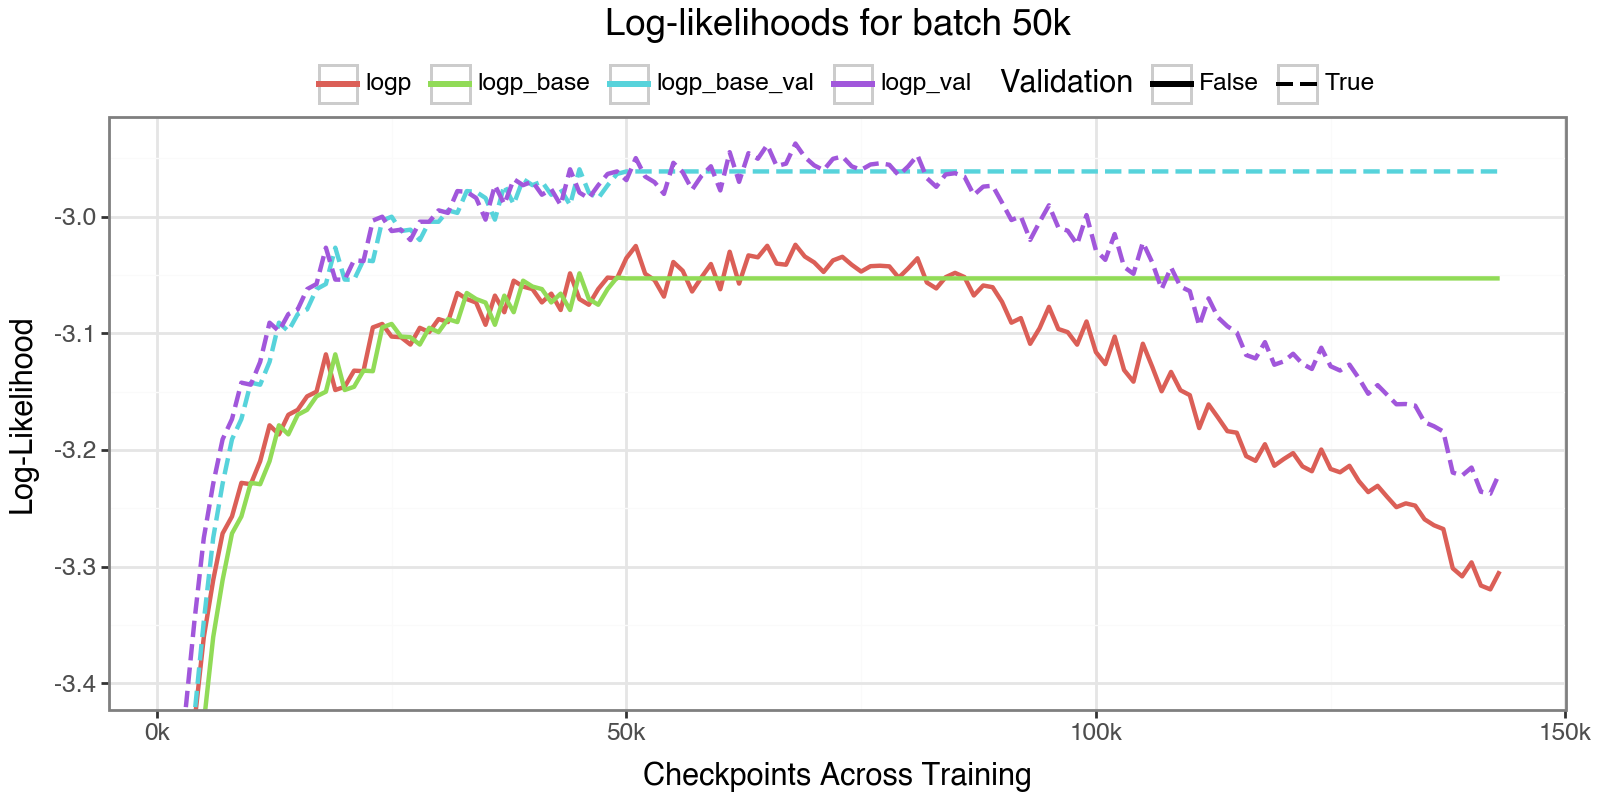

In [257]:
(
    pn.ggplot(pdata.filter(pl.col("is_logp")), pn.aes("step", "value", colour="variable", linetype="is_val"))
    + pn.geom_line(size=.9)
    + pn.theme_bw()
    + pn.coord_cartesian(ylim=(-3.4, None))
    + pn.scale_x_continuous(labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.labs(
        title=f"Log-likelihoods for batch {batch_idx / 1000:.0f}k", 
        y="Log-Likelihood", 
        x="Checkpoints Across Training", 
        colour="", 
        linetype="Validation",
    )
    + pn.scale_colour_discrete()
    + pn.theme(
        plot_margin=0.005, 
        plot_background=None, 
        legend_box_spacing=0.005, 
        legend_box_margin=0, 
        figure_size=(8, 4), 
        legend_position="top"
    )
    # + pn.facet_grid("is_logp", scales="free_y")
)

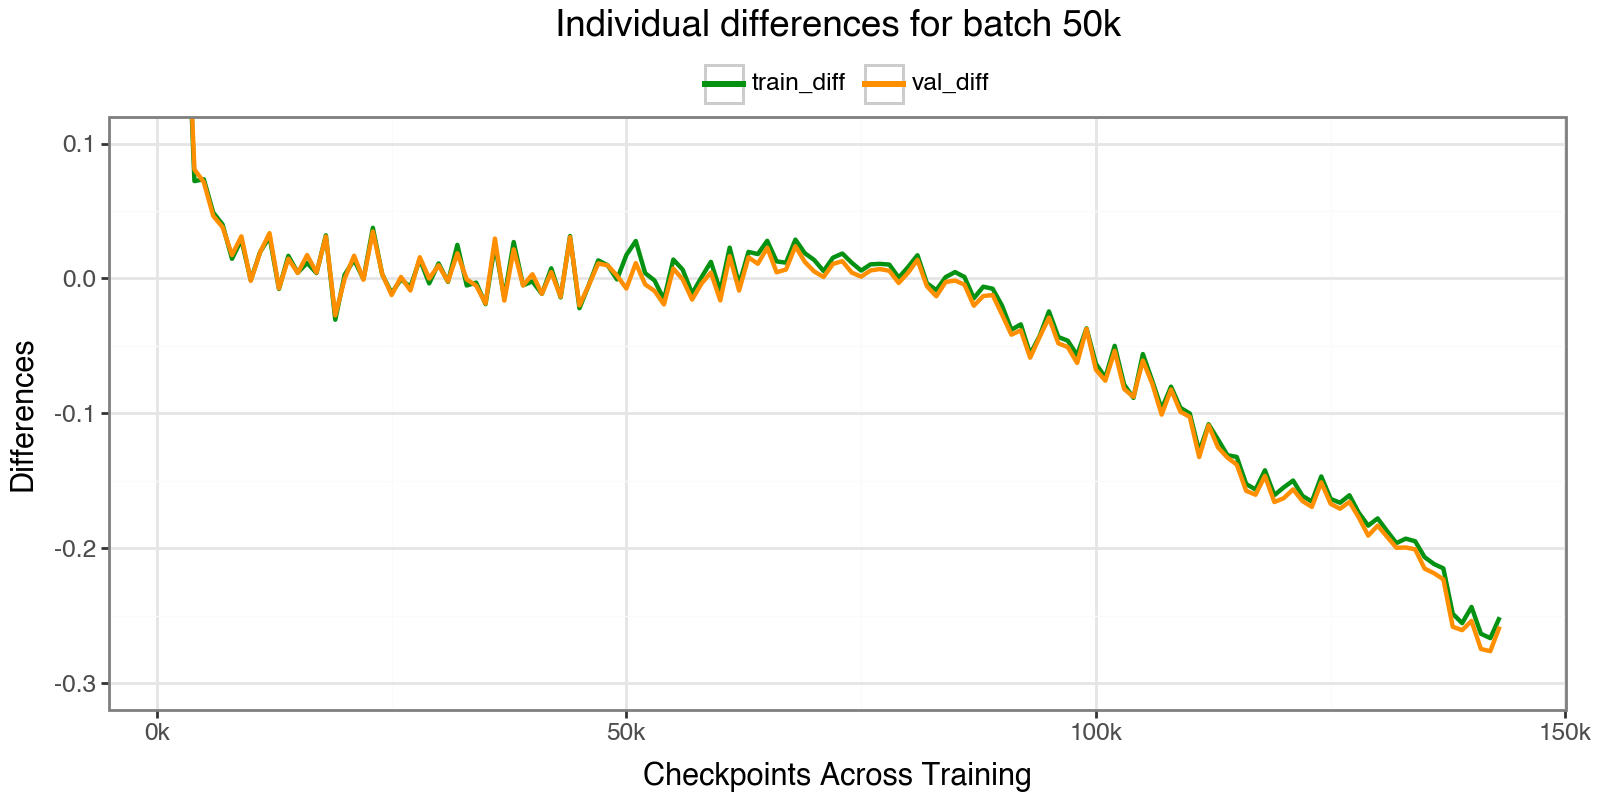

In [258]:
(
    pn.ggplot(pdata.filter(pl.col("is_diff")), pn.aes("step", "value", colour="variable"))
    + pn.geom_line(size=.9)
    + pn.theme_bw()
    + pn.coord_cartesian(ylim=(-0.3, 0.1))
    + pn.scale_x_continuous(labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.labs(
        title=f"Individual differences for batch {batch_idx / 1000:.0f}k", 
        y="Differences", 
        x="Checkpoints Across Training", 
        colour="",
    )
    + pn.scale_colour_manual(values=["#059212", "#FF8F00"])
    + pn.theme(
        plot_margin=0.005, 
        plot_background=None, 
        legend_box_spacing=0.005, 
        legend_box_margin=0, 
        figure_size=(8, 4), 
        legend_position="top"
    )
)

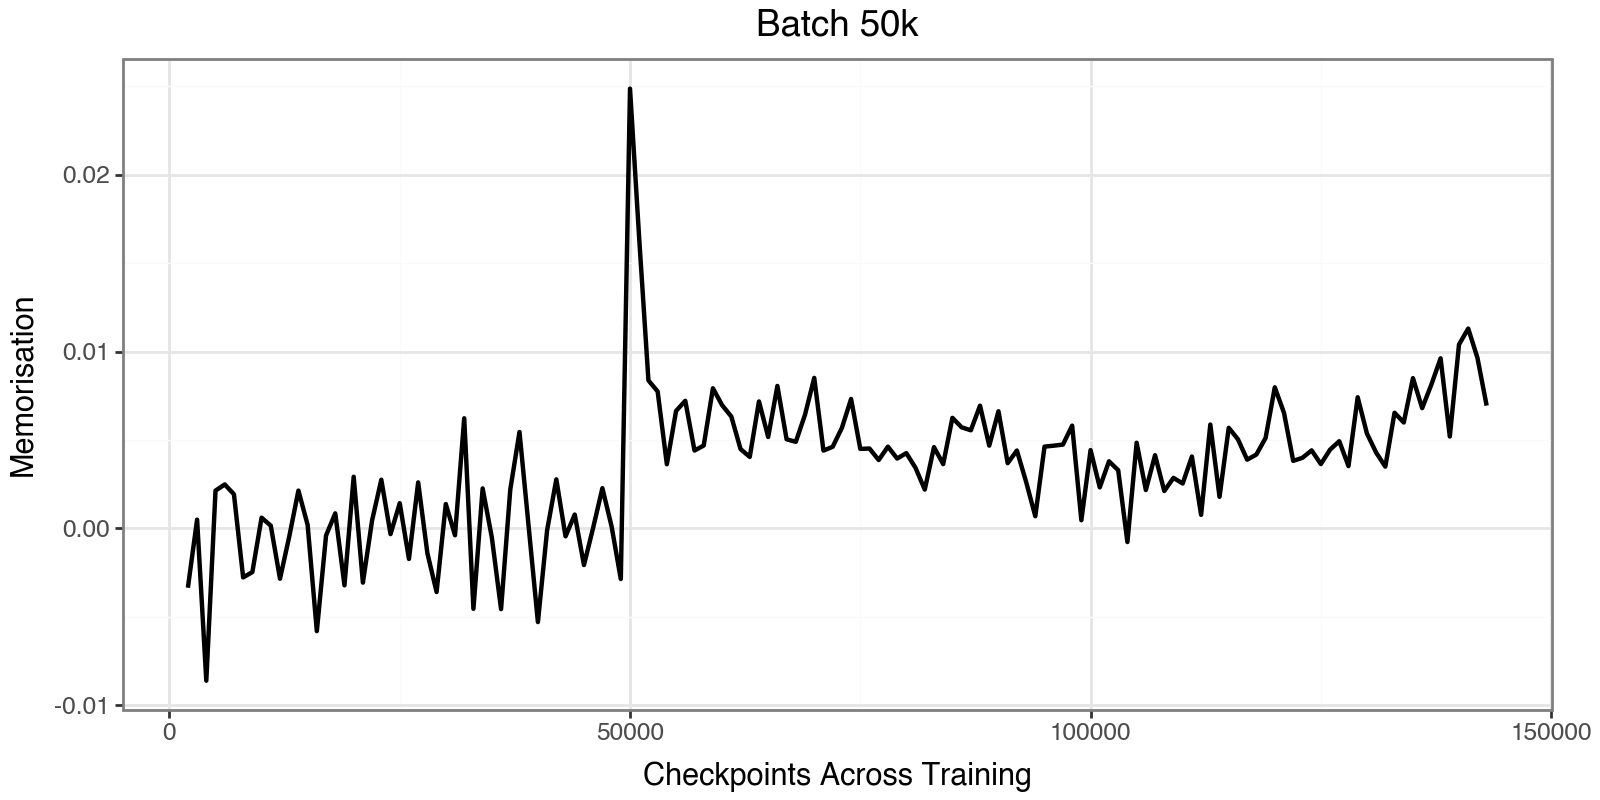

In [260]:
(
    pn.ggplot(pdata.filter(pl.col("is_mem")), pn.aes("step", "value"))
    + pn.geom_line(size=.9)
    + pn.theme_bw()
    + pn.labs(
        title=f"Batch {batch_idx / 1000:.0f}k", 
        y="Memorisation", 
        x="Checkpoints Across Training", 
    )
    + pn.theme(
        plot_margin=0.005, 
        plot_background=None, 
        legend_box_spacing=0.005, 
        legend_box_margin=0, 
        figure_size=(8, 4), 
        legend_position="top"
    )
)

In [298]:
import numpy as np
from tqdm.auto import tqdm

def multiplier_bootstrap_ATTgt_from_df(df: pl.DataFrame, B: int = 1000):
    """
    Applies the Simple Multiplier Bootstrap to ATT_{g,t} estimates 
    from a DataFrame containing batch_idx, step, and mem columns.

    Parameters:
    - df: DataFrame with columns [batch_idx, step, mem] containing ATT_{g,t} estimates.
    - B: int, number of bootstrap replications.

    Returns:
    - result_df: DataFrame with [batch_idx, step, ATT_hat, SE, p_value].
    """
    # Initialize list to store results
    results = []
    groups = df.group_by(['batch_idx', "step"])

    # Group by batch_idx (g) and step (t) to apply the bootstrap per group
    for (g, t), group in tqdm(groups, total=len(list(groups))):
        estimates = group['mem'].to_numpy()  # Extract ATT_{g,t} estimates
        n = len(estimates)
        
        # Compute the original estimate (mean of the group estimates)
        ATT_hat = np.mean(estimates)

        # Perform the bootstrap
        bootstrap_estimates = np.zeros(B)
        for b in range(B):
            multipliers = np.random.normal(0, 1, n)  # Normal(0, 1) multipliers
            bootstrap_estimates[b] = np.mean(multipliers * estimates)

        # Compute standard error
        SE = np.std(bootstrap_estimates, ddof=1)

        # Compute two-sided p-value
        p_value = np.mean(np.abs(bootstrap_estimates) >= np.abs(ATT_hat))

        # Store results
        results.append({
            'batch_idx': g,
            "step": t,
            'ATT_hat': ATT_hat,
            'SE': SE,
            'p_value': p_value
        })

    # Convert results to DataFrame
    result_df = pl.DataFrame(results)
    return result_df

result_df = multiplier_bootstrap_ATTgt_from_df(train_df.select(["batch_idx", "step", "mem"]))
print(result_df)


  0%|          | 0/20592 [00:00<?, ?it/s]

shape: (20_592, 5)
┌───────────┬────────┬───────────┬──────────┬─────────┐
│ batch_idx ┆ step   ┆ ATT_hat   ┆ SE       ┆ p_value │
│ ---       ┆ ---    ┆ ---       ┆ ---      ┆ ---     │
│ i64       ┆ i64    ┆ f64       ┆ f64      ┆ f64     │
╞═══════════╪════════╪═══════════╪══════════╪═════════╡
│ 74000     ┆ 0      ┆ 0.034912  ┆ 0.065318 ┆ 0.609   │
│ 87000     ┆ 126000 ┆ 0.006839  ┆ 0.004246 ┆ 0.098   │
│ 88000     ┆ 104000 ┆ 0.001014  ┆ 0.002791 ┆ 0.707   │
│ 112000    ┆ 34000  ┆ -0.000914 ┆ 0.003692 ┆ 0.792   │
│ 123000    ┆ 104000 ┆ 0.008588  ┆ 0.004528 ┆ 0.053   │
│ 43000     ┆ 87000  ┆ -0.001017 ┆ 0.004376 ┆ 0.813   │
│ 47000     ┆ 67000  ┆ 0.003492  ┆ 0.003717 ┆ 0.342   │
│ 57000     ┆ 77000  ┆ 0.00032   ┆ 0.003028 ┆ 0.915   │
│ 88000     ┆ 13000  ┆ 0.000386  ┆ 0.002951 ┆ 0.889   │
│ 95000     ┆ 95000  ┆ 0.014655  ┆ 0.002438 ┆ 0.0     │
│ 108000    ┆ 1000   ┆ -0.052387 ┆ 0.084986 ┆ 0.529   │
│ 120000    ┆ 33000  ┆ 0.002359  ┆ 0.002714 ┆ 0.39    │
│ 28000     ┆ 54000  ┆ 0.0032

In [308]:
result_df.filter(pl.col("batch_idx") == 1000).sort("step")

batch_idx,step,ATT_hat,SE,p_value
i64,i64,f64,f64,f64
1000,0,0.124851,0.062879,0.04
1000,1000,-0.103558,0.068357,0.129
1000,2000,-0.116346,0.065612,0.076
1000,3000,-0.124602,0.06118,0.05
1000,4000,-0.124234,0.061153,0.038
1000,5000,-0.12936,0.062806,0.036
1000,6000,-0.127216,0.062825,0.039
1000,7000,-0.127592,0.062528,0.038
1000,8000,-0.130361,0.062695,0.044


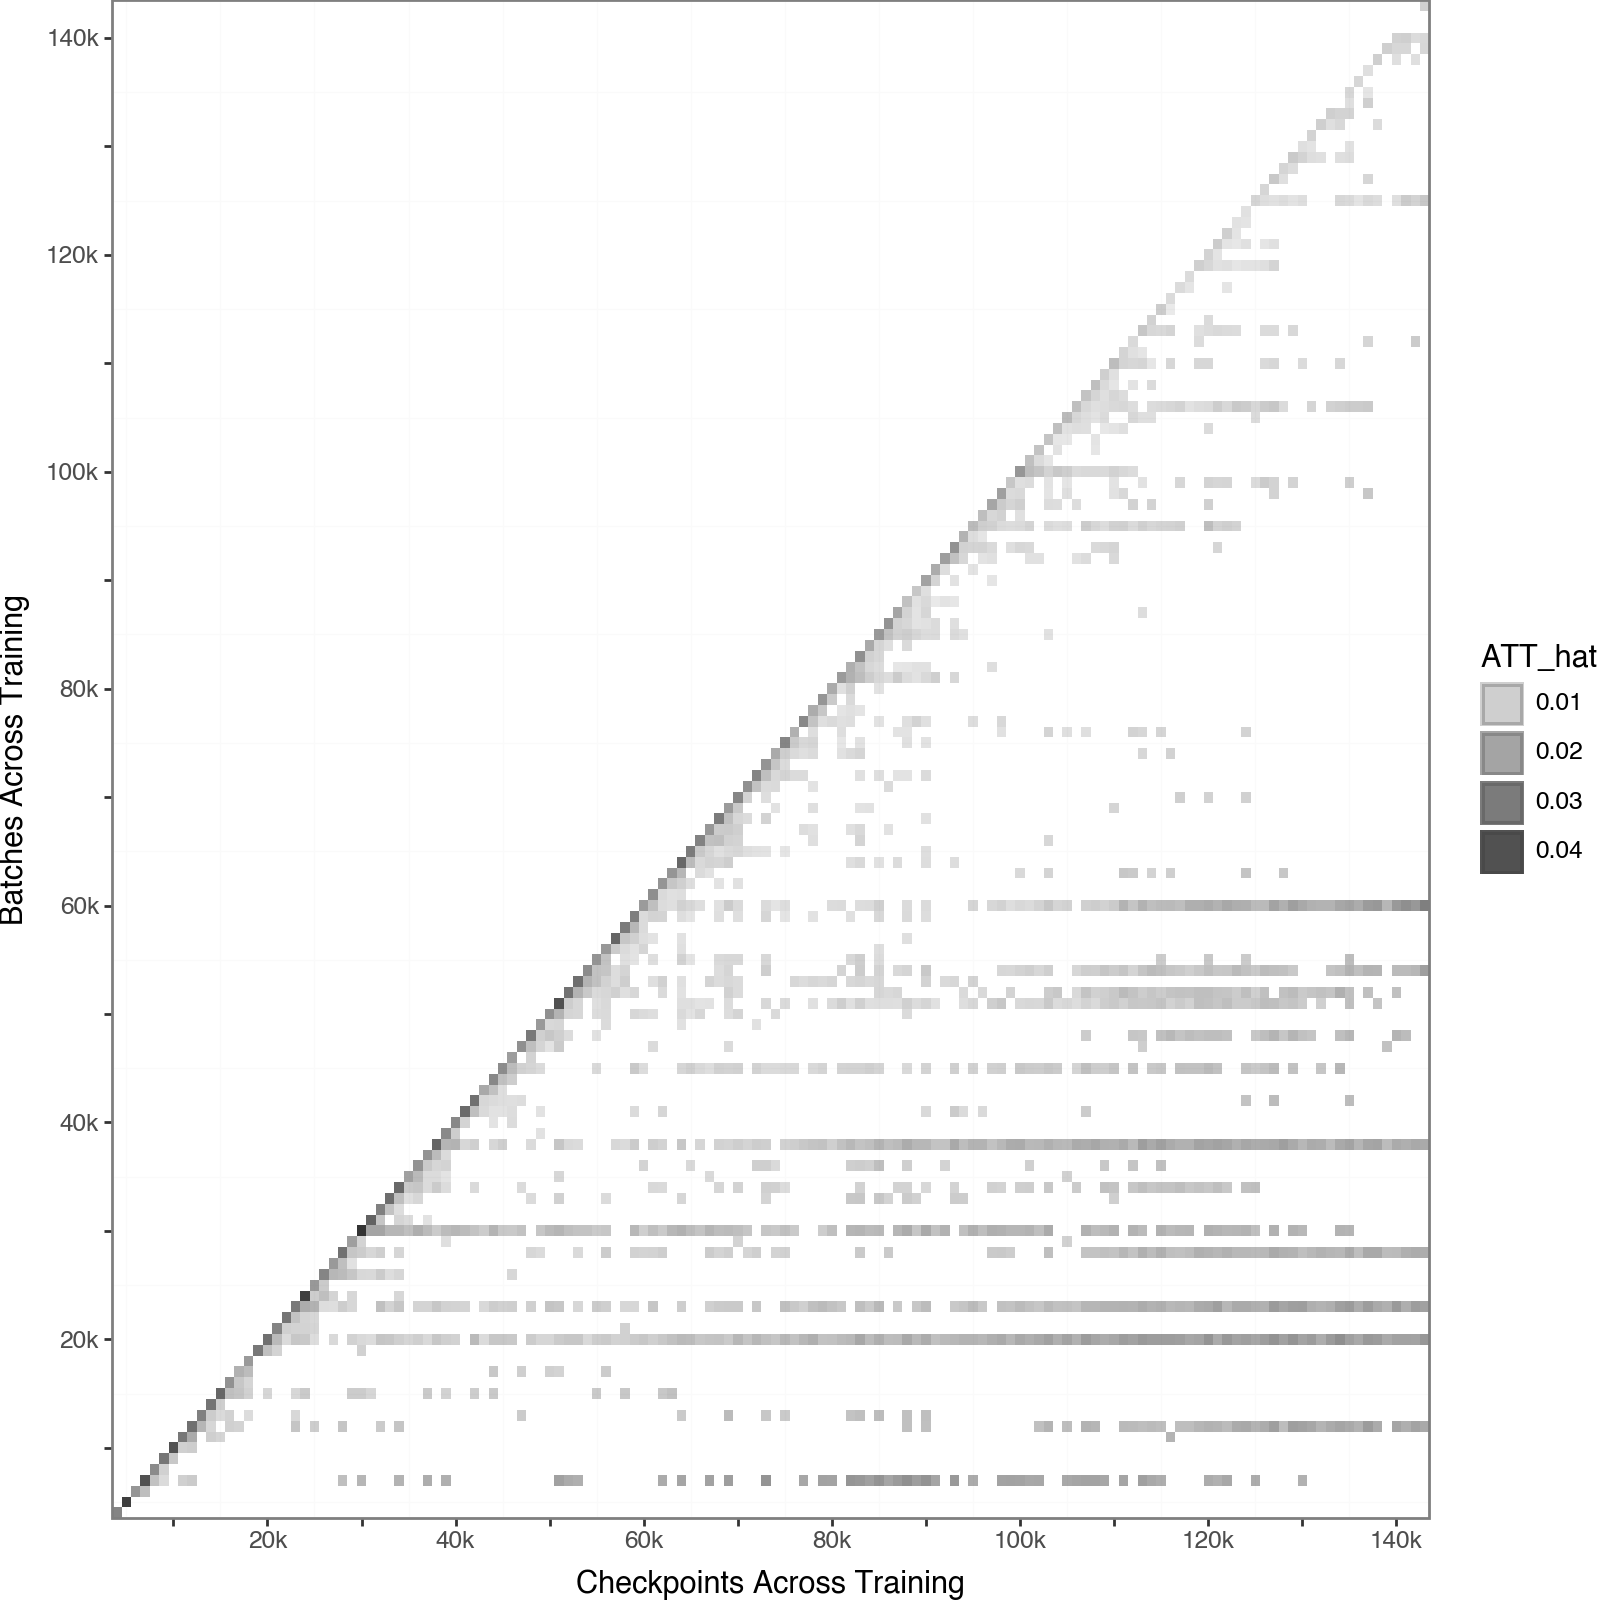

In [305]:
pdata = result_df.filter((pl.col("p_value") < 0.05) & (pl.col("step") >= pl.col("batch_idx")) & (pl.col("ATT_hat") > 0))
(
    pn.ggplot(pdata, pn.aes("step", "batch_idx", alpha="ATT_hat")) +
    pn.geom_tile(pn.aes(width=1000, height=1000)) +
    pn.labs(title="", x="Checkpoints Across Training", y="Batches Across Training") +
    pn.scale_x_continuous(
        expand=(0, 0), 
        breaks=range(0, 143000, 10000),
        labels=lambda x: [f"{v / 1000:.0f}k" if v % 20000 == 0 and v != 0 else "" for v in x],
    ) +
    pn.scale_y_continuous(
        expand=(0, 0), 
        breaks=range(0, 143000, 10000), 
        labels=lambda x: [f"{v / 1000:.0f}k" if v % 20000 == 0 and v != 0 else "" for v in x],
    ) +
    # pn.scale_alpha(range=(.5, 1.), guide=None) +
    pn.theme_bw(base_size=11) +
    pn.theme(panel_grid_major=pn.element_blank(), plot_margin=0, plot_background=None, figure_size=(8, 8))
)

In [103]:
val_df

step,sup_seq
i32,f64
0,11.012991
1000,4.268897
2000,3.670751
3000,3.427454
4000,3.346674
…,…
139000,3.221883
140000,3.215072
141000,3.235829


In [99]:
val_df.with_columns(pl.col("step") - 1000)

step,sup_seq
i32,f64
-1000,11.012991
0,4.268897
1000,3.670751
2000,3.427454
3000,3.346674
…,…
138000,3.221883
139000,3.215072
140000,3.235829


In [ ]:
train_df.join(val_df, on=["step"])

In [44]:
dd = pl.concat([train_df, val_df.select(train_df.columns)])

In [45]:
dd.sort(["seq_idx", "step"])

seq_idx,step,sup_seq
i32,i32,f64
-1,0,11.012991
-1,1000,4.268897
-1,2000,3.670751
-1,3000,3.427454
-1,4000,3.346674
…,…,…
143000,143000,1.860588
143000,143000,3.882281
143000,143000,3.909403
